In [1]:
from PIL import Image
import os
import shutil

import replicate
from dotenv import load_dotenv

In [2]:
# load vars from .env
load_dotenv()

# set replicate api key
replicate = replicate.Client(api_token=os.getenv("REPLICATE_API_KEY"))

In [3]:
# Set input and output directories
input_dir = "raw/"  # Change this to your folder
output_dir = "data/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# image counter
i = 0

# Process each image
for filename in os.listdir(input_dir):
    # Check for PNG and JPEG
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)

        # Get original dimensions
        width, height = img.size
        new_size = min(width, height)  # Smallest dimension for square crop

        # Calculate cropping box (centered)
        left = (width - new_size) // 2
        top = (height - new_size) // 2
        right = left + new_size
        bottom = top + new_size

        # Crop the image
        img_cropped = img.crop((left, top, right, bottom))

        # Resize to 1024x1024 using high-quality resampling
        img_resized = img_cropped.resize((1024, 1024), Image.LANCZOS)

        # Crop and save the image
        output_path = os.path.join(output_dir, f"img-{i}.png")
        img_resized.save(output_path, format="PNG")
        i += 1

In [4]:
import os
import google.generativeai as genai

genai.configure(api_key=os.environ["GEMINI_API_KEY"])

def upload_to_gemini(path, mime_type=None):
  file = genai.upload_file(path, mime_type=mime_type)
  print(f"Uploaded file '{file.display_name}' as: {file.uri}")
  return file

# Create the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,
)

files = [
  upload_to_gemini("data/img-0.png", mime_type="image/png"),
]

chat_session = model.start_chat(
  history=[
    {
      "role": "user",
      "parts": [  
        files[0],
      ],
    },
  ]
)

response = chat_session.send_message("Please describe the image with a short caption. Only output one caption with a max of 10 words ")

print(response.text)

Uploaded file 'img-0.png' as: https://generativelanguage.googleapis.com/v1beta/files/e191a15pwcab
Smiling man in glasses, outdoors.



In [5]:
for filename in os.listdir(output_dir):
    if filename.lower().endswith('.png'):
        img_path = os.path.join(output_dir, filename)
        image = open(img_path, "rb")

        # generate caption
        files = upload_to_gemini(img_path, mime_type="image/png")

        chat_session = model.start_chat(
            history=[
                {
                "role": "user",
                "parts": [  
                    files,
                ],
                },
            ]
            )
        response = chat_session.send_message("Please describe the image with a short caption. Only output one caption with a max of 50 words and if there a man in the picture refer to him as Hari ")

        caption = f"A photo of Hari. {response.text}"
        caption_filename = img_path.split('.')[0] + '.txt'
        with open(caption_filename, "w") as file:
            print(caption)
            file.write(caption)

Uploaded file 'img-20.png' as: https://generativelanguage.googleapis.com/v1beta/files/81m1f6vglx8p
A photo of Hari. Here's a caption for the image:

Hari proudly stands beside a Formula 1 race car, a sunny day at an outdoor event.  The backdrop features lush green trees and a vibrant blue sky.

Uploaded file 'img-3.png' as: https://generativelanguage.googleapis.com/v1beta/files/dnox6ohe4orj
A photo of Hari. Hari proudly stands between his two motorcycles, a sleek Honda and a classic Jawa, showcasing his love for vintage and modern machines.

Uploaded file 'img-2.png' as: https://generativelanguage.googleapis.com/v1beta/files/qso2m1d5rrrx
A photo of Hari. Hari, adorned in a vibrant green dhoti and gold accents, stands poised and smiling.  A garland of marigolds decorates the background.  The image suggests a festive or ceremonial occasion.

Uploaded file 'img-21.png' as: https://generativelanguage.googleapis.com/v1beta/files/rtfw6j0htas0
A photo of Hari. Hari proudly displays his Outsta

In [6]:
# inputs: name of .zip file, compression format, directory to compress
shutil.make_archive("data", 'zip', "data/")

'/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/FLUX-1-Finetuning/data.zip'

In [8]:
model = replicate.models.create(
    owner="harikrishnad1997",
    name="flux-1-hari-ft",
    visibility="private",  # or "private" if you prefer
    hardware="gpu-t4",  # Replicate will override this for fine-tuned models
    description="FLUX.1 finetuned on photos of me (Hari)"
)
 
print(f"Model created: {model.name}")
print(f"Model URL: https://replicate.com/{model.owner}/{model.name}")

Model created: flux-1-hari-ft
Model URL: https://replicate.com/harikrishnad1997/flux-1-hari-ft


In [9]:
training = replicate.trainings.create(
    version="ostris/flux-dev-lora-trainer:4ffd32160efd92e956d39c5338a9b8fbafca58e03f791f6d8011f3e20e8ea6fa",
    input={
        "input_images": open("data.zip", "rb"),
        "steps": 1000,
        # "hf_token": "YOUR_HUGGING_FACE_TOKEN",  # optional
        # "hf_repo_id": "YOUR_HUGGING_FACE_REPO_ID",  # optional
    },
    destination=f"{model.owner}/{model.name}"
)
 
print(f"Training started: {training.status}")
print(f"Training URL: https://replicate.com/p/{training.id}")

Training started: starting
Training URL: https://replicate.com/p/vd0p83r8pxrm80cmx32sskw8bc


In [16]:
import replicate

output = replicate.run(
    "harikrishnad1997/flux-1-hari-ft:37b22168a51d814b49bc8629cca6caaa6789a8a7b65cdd5123310fe5a5c5fecc",
    input={
        "prompt": "A picture of Hari playing cricket without a helmet for India in Lords",
        "num_inference_steps": 28,
        "guidance_scale": 7.5,
        "model": "dev",
        "num_outputs":4,
    }
)
 
print(f"Generated image URL: {output}")

Generated image URL: [<replicate.helpers.FileOutput object at 0x11fe68c80>, <replicate.helpers.FileOutput object at 0x11fe68cb0>, <replicate.helpers.FileOutput object at 0x11fe68e30>, <replicate.helpers.FileOutput object at 0x11fe68dd0>]


In [17]:
for i in output:
    print(i)

https://replicate.delivery/xezq/VhpbmOvJX5J8GRGkmddezaqoztXMKQpKpmxXFtkZaTPQvuGKA/out-0.webp
https://replicate.delivery/xezq/o9bJo986WNp6GFwRRexOoSITOicYwJypfTwTriSQOBDge6aoA/out-1.webp
https://replicate.delivery/xezq/idsxc76x9kLaM5yctwDm4WTmuRbNxedO0nuxgFucmdJQvuGKA/out-2.webp
https://replicate.delivery/xezq/f55vE3uT2p3bFCacf15fBeiq4Bzn4TIz5h71mByp6JKC611QB/out-3.webp


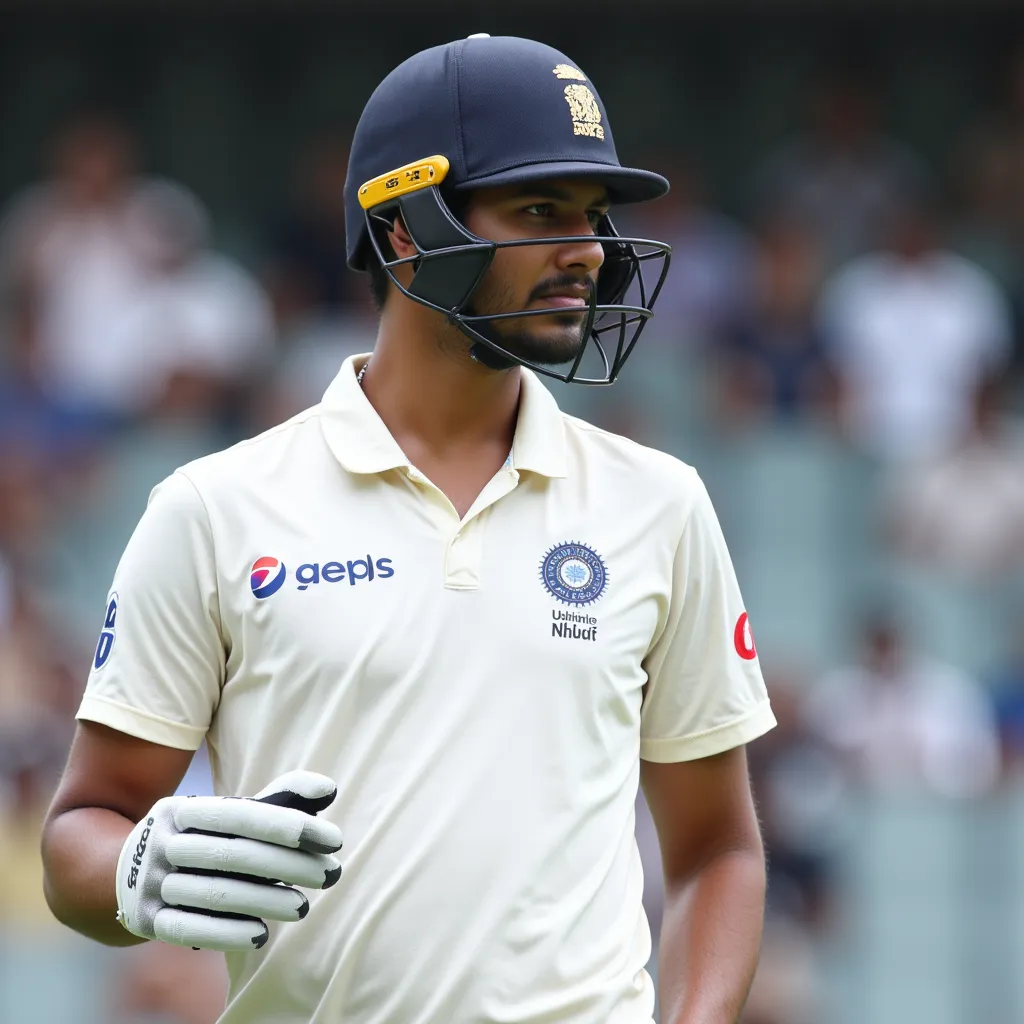

In [18]:
from PIL import Image
import requests

im = Image.open(requests.get(output[0], stream=True).raw)

im

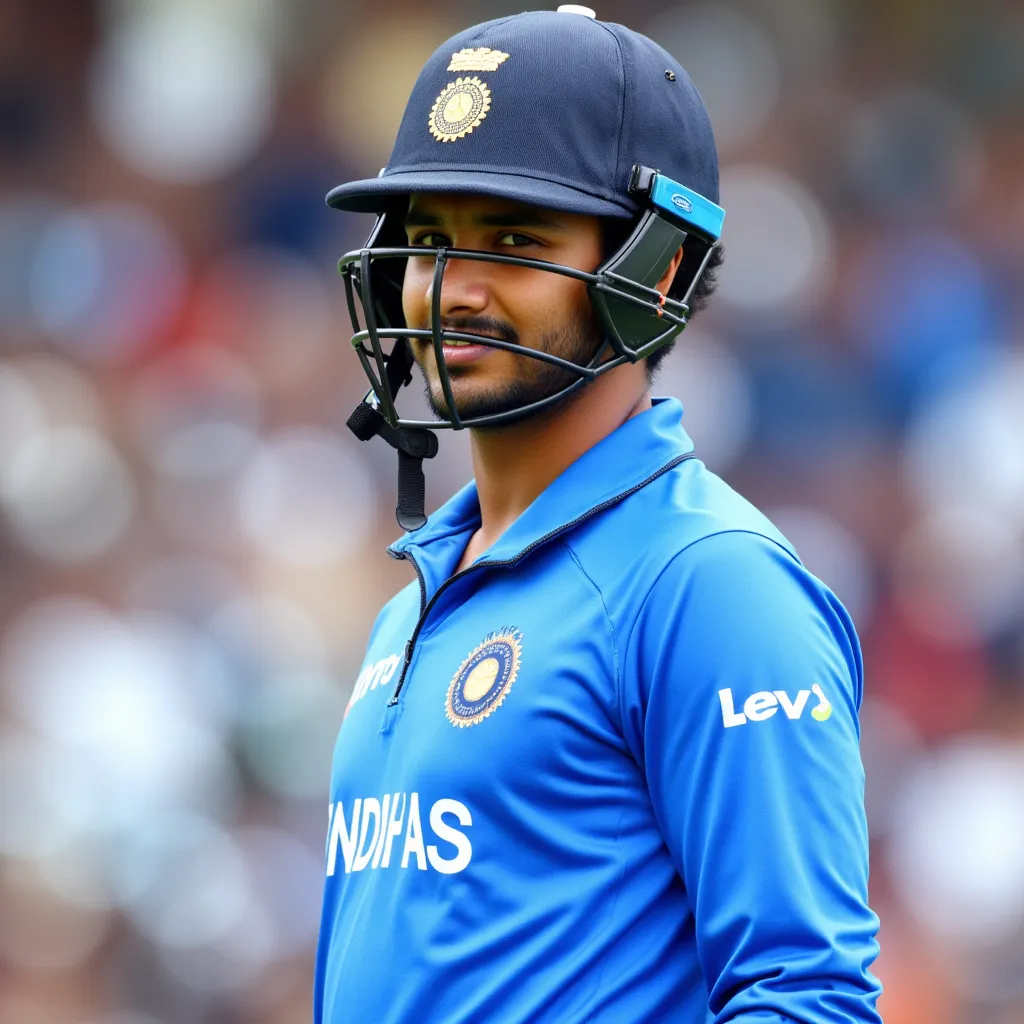

In [19]:
im = Image.open(requests.get(output[1], stream=True).raw)
im

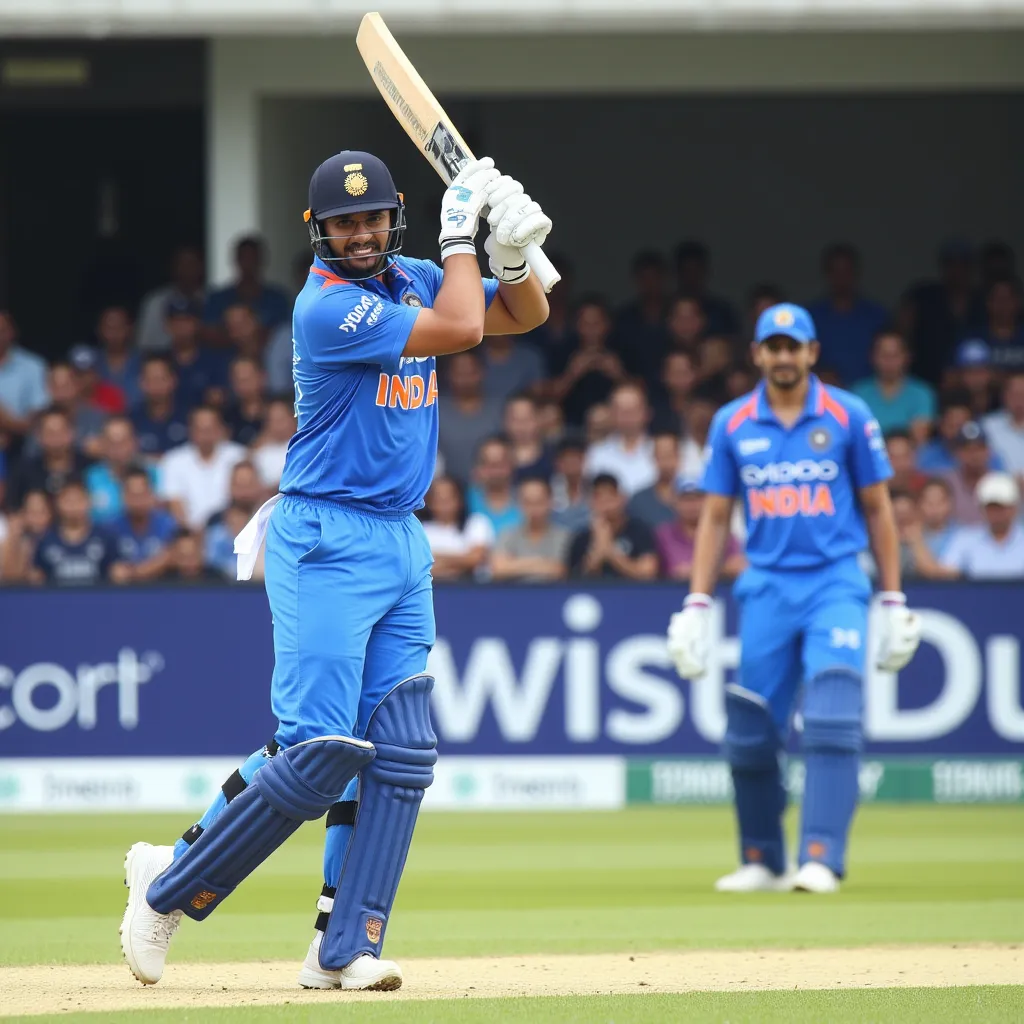

In [20]:
im = Image.open(requests.get(output[2], stream=True).raw)
im

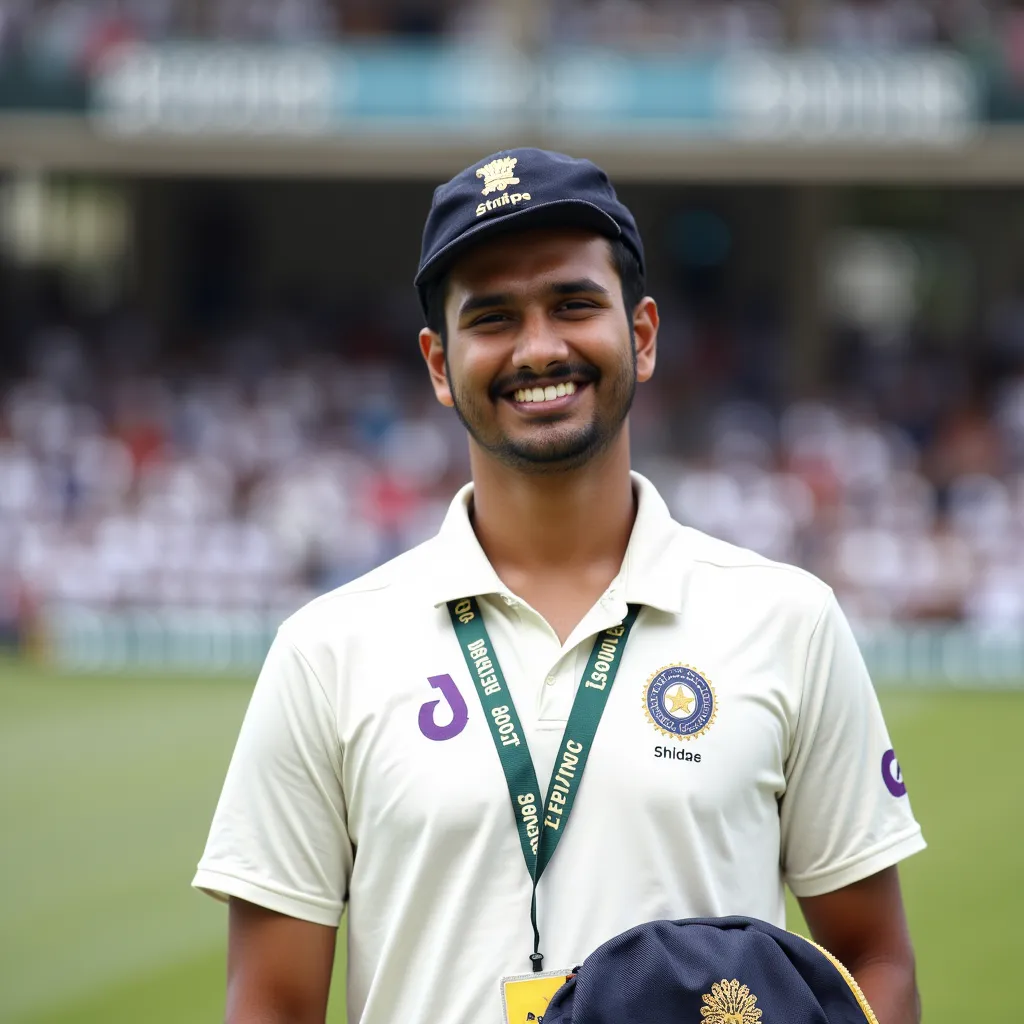

In [21]:
im = Image.open(requests.get(output[3], stream=True).raw)
im